<p style="font-size: 40px; font-weight: bold; text-align: center;">Household electric power consumption</p>

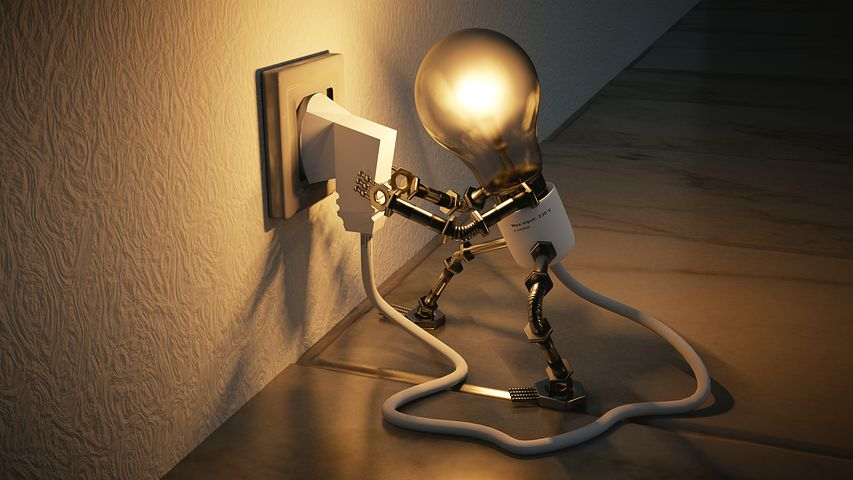

<h2>Dataset Information:</h2>

1. <b>Date: Date in format dd/mm/yyyy </b>
2. <b>Time: time in format hh:mm:ss </b>
3. <b>Global_active_power: household global mi|nute-averaged active power (in kilowatt) </b>
    * Global active power is a term used in electrical engineering to<br> refer to the total active power consumption of a building or an entire electrical<br> grid. It is a measure of the real power used by electrical devices and is expressed in watts (W).<br><br>
4. <b>Global_reactive_power: household global minute-averaged reactive power (in kilowatt) </b>
    * Global reactive power is a term used in electrical engineering to refer to the<br> total reactive power consumption of a building or an entire electrical grid.<br> It is a measure of the amount of electrical power that is flowing back and forth between<br> the source and the load in an alternating current (AC) electrical system, and it doesn't do any <br>useful work, but it is necessary to maintain the voltage level in the system. It is expressed in volt-amperes reactive (VAR).<br><br>
5. <b>Voltage: minute-averaged voltage (in volt) </b>
    * Voltage, also known as electric potential difference, is a <br>measure of the electrical potential energy per unit charge in an electrical circuit. It is the force that drives<br> the flow of electric charge in a circuit, and is expressed in volts (V).<br><br>
6. <b>Global_intensity: household global minute-averaged current intensity (in ampere) </b>
    * Global intensity refers to the overall or average current flow <br>in an electrical system or network, such as a building or an entire electrical grid. It is a measure of the <br>amount of electric charge moving through a conductor per unit of time and is expressed in amperes (A).<br><br>
7. <b>Sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). </b>
    * It corresponds to the kitchen, containing mainly a dishwasher,<br> an oven and a microwave (hot plates are not electric but gas powered).<br><br>
8. <b>Sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). </b>
    * It corresponds to the laundry room, containing a washing-machine,<br> a tumble-drier, a refrigerator and a light.<br><br>
9. <b>Sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). </b>
    * It corresponds to an electric water-heater and an air-conditioner.<br><br>

## Import libraries

In [1]:
# Data Serialization
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from keras.models import load_model

# Data manipulation and computation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Scalling
from sklearn.preprocessing import MinMaxScaler

# Encoding
from feature_engine.encoding import OneHotEncoder

# Deep learning models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    AveragePooling2D,
    Dropout,
    LSTM
)

from tensorflow.keras.optimizers import (
    Adam, 
    SGD, 
    RMSprop,
    Adamax
)

from scikeras.wrappers import KerasRegressor

# Callback functions
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint
)

# Importing Scikit-Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error
)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2023-02-27 14:44:23.860558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Functions

In [2]:
def plot_day_data(day:datetime.date) -> None:
    '''
    The function "plot_day_data" plots the "Global_active_power" values 
    for a given date as input. The input date is used to filter the data
    and fill in any missing values with NaN. On the plot, the missing
    values are marked with markers. The X-axis displays xticks for the
    specified day and the Y-axis is labeled as "value". The final plot 
    is displayed using the matplotlib library.
    
    Parameters:
        day : datetime.date
        
    Return:
        None
    '''
    # Create time range and xtick for the day
    time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1T')
    xtick_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='D')
    
    # Filter the data for the day and fill missing values with NaN
    tmp_df = data[['Global_active_power']][data.index.isin(time_range)].copy()
    tmp_df = tmp_df.combine_first(pd.DataFrame(index=time_range, columns=tmp_df.columns))
    
    # Calculate the marker place
    marker_place = tmp_df[['Global_active_power']].max().item() / 2
    # Identify the missing values
    missing_values = tmp_df.isna().any(axis=1)
    
    # Drawing the plot
    plt.figure(figsize=(15, 5))
    plt.plot(
        tmp_df[['Global_active_power']][~missing_values],
        label = 'Normal Data'
    )
    plt.plot(
        tmp_df[['Global_active_power']][missing_values].fillna(marker_place), 
        marker='o', 
        linestyle='None',
        label = 'Missing Data',
        color = 'r'
    )
    plt.xticks(xtick_range, rotation=90)
    plt.grid(axis='y')
    plt.title('Global_active_power ({}:{})'.format(str(time_range[1].date()),str(time_range[-1].date())),fontsize=15)
    plt.ylabel('value')
    plt.legend()
    plt.show()
    
    return None

In [3]:
def feature_analyser(feature:str,df:pd.DataFrame) -> None:
    '''
    This function is to plot mean value of 
    given feature resampled over 'M','Q' and 'Y'

    Parameters:
        feature : string : Column name in the dataframe to be analyzed.
        df : Pandas dataframe : Dataframe to be used for analysis.

    Returns:
        None
    '''
    # Create subplots with 3 rows and 1 column, and set figure size
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,20))
    plt.subplots_adjust(hspace=0.6)  
    
    # Loop through resample intervals: monthly, quarterly, and yearly
    for number, resample in enumerate(['M', 'Q', 'Y']):
        
        df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
        ax[number].set_ylabel('{} mean'.format(feature))
        
        # Set title for each subplot
        if resample == 'M':
            ax[number].set_title('{} per month'.format(feature), fontsize=20)
        if resample == 'Q':
            ax[number].set_title('{} per quarter'.format(feature), fontsize=20)
        if resample == 'Y':
            ax[number].set_title('{} per year'.format(feature), fontsize=20)
            
        ax[number].set_xlabel('')
        ax[number].grid(axis='y')
        plt.xticks(rotation=90)
        
    plt.show()
    
    print('-----------------------------')
    
    return None

In [68]:
def LSTM_df_generator(df:pd.DataFrame(), rows_before:int=1, rows_after:int=0) -> pd.DataFrame():
    '''
    Generate a dataframe for use in LSTM models by shifting 
    the input dataframe and concatenating the shifted dataframes.
    
    Parameters:
        - df: input dataframe
        - rows_before: number of rows before the current row to shift the dataframe
        - rows_after: number of rows after the current row to shift the dataframe
    
    Returns:
        - A new dataframe with the shifted data and concatenated along the columns axis.
    '''

    # Initialize two empty lists to store the dataframes and column names
    total_df_list, columns = [], []
    
    # Loop through each row, from rows before the current row to rows after
    for row in range(-rows_before, rows_after + 1):
        # Shift the dataframe by `row` and append it to the list of dataframes
        total_df_list.append(df.shift(row))
        
        # Generate the column names based on the row index
        if row < 0:
            cols = [f'{col}(t-{-row})' for col in df.columns]
        
        elif row == 0:
            cols = [f'{col}(t)' for col in df.columns]
        
        else:
            cols = [f'{col}(t+{row})' for col in df.columns]
        
        # Add the generated column names to the list of column names
        columns.extend(cols)
    
    # Concatenate the dataframes and set the column names
    total_df = pd.concat(total_df_list, axis=1)
    total_df.columns = columns
    
    # Drop any rows with missing values
    total_df.dropna(inplace=True)
    
    # Drop notpredicting columns
    
    total_df.drop(columns=total_df.columns[-len(df.columns[1:]):],inplace=True)
    
    # Return the resulting dataframe
    return total_df

In [5]:
def create_model(
    units:int = 50, 
    dropout_rate:float = 0.2, 
    optimizer:'optimizers' = Adam, 
    learning_rate:float = 0.001, 
    batch_size:int = 100,
    epochs:int = 20
) -> 'model':
    '''
    This function creates a multi-layer RNN using LSTM with 
    two LSTM layers, a dropout layer, and a dense layer. 
    It optimizes the model using the Adam optimizer with
    a specified learning rate and compiles it using mean
    squared error loss. Arguments include number of units,
    dropout rate, optimizer, learning rate, batch size,
    and number of epochs.
    '''
    # Initialize the sequential model
    model = Sequential()
    
    # Add the first LSTM layer
    model.add(LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    
    # Add the dropout layer
    model.add(Dropout(dropout_rate))
    
    # Add the second LSTM layer
    model.add(LSTM(units=units))
    
    # Add the dropout layer
    model.add(Dropout(dropout_rate))
    
    # Add the dense layer
    model.add(Dense(units=1))
    
    # Initialize the optimizer
    optimizer = optimizer(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(loss='mse', metrics=['mse'], optimizer=optimizer)
    
    # Return the compiled model
    return model

In [34]:
def get_weekday(datetime_obj:pd.Timestamp) -> str:
    '''
    Get the day of the week as a string value, given a Pandas Timestamp object.
    
    Parameters:
        - datetime_obj : A Pandas Timestamp object representing a specific date and time.
    
    Returns:
        - A string value representing the corresponding day of the week (Monday through Sunday).
    '''
    weekday = datetime_obj.weekday()
    
    if weekday == 0:
        return 'monday'
    if weekday == 1:
        return 'tuesday'
    if weekday == 2:
        return 'wednesday'
    if weekday == 3:
        return 'thursday'
    if weekday == 4:
        return 'friday'
    if weekday == 5:
        return 'saturday'
    if weekday == 6:
        return 'sunday'

In [35]:
def get_season(datetime_obj:pd.Timestamp) -> str:
    '''
    Get the season as a string value, given a Pandas Timestamp object.
    
    Parameters:
        - datetime_obj : A Pandas Timestamp object representing a specific date and time.

    
    Returns:
        - A string value representing the corresponding season (winter, spring, summer, or fall).
    '''
    month = datetime_obj.month

    if month == 12 or month <= 2:
        return 'winter'
    elif month <= 5:
        return 'spring'
    elif month <= 8:
        return 'summer'
    elif month <= 11:
        return 'fall'

## Import Dataset

In [6]:
# Read the CSV file 'household_power_consumption.txt' into a pandas DataFrame
data = pd.read_csv(
    'household_power_consumption.txt', 
    sep = ';', 
    parse_dates = {'dt' : ['Date', 'Time']},
    infer_datetime_format = True, 
    na_values = ['nan','?'],
    index_col = 'dt'
)

# Drop all rows with missing values (NaN)
data.drop(index=data[data.isnull().any(axis=1)].index,inplace=True)

## Data exploration 

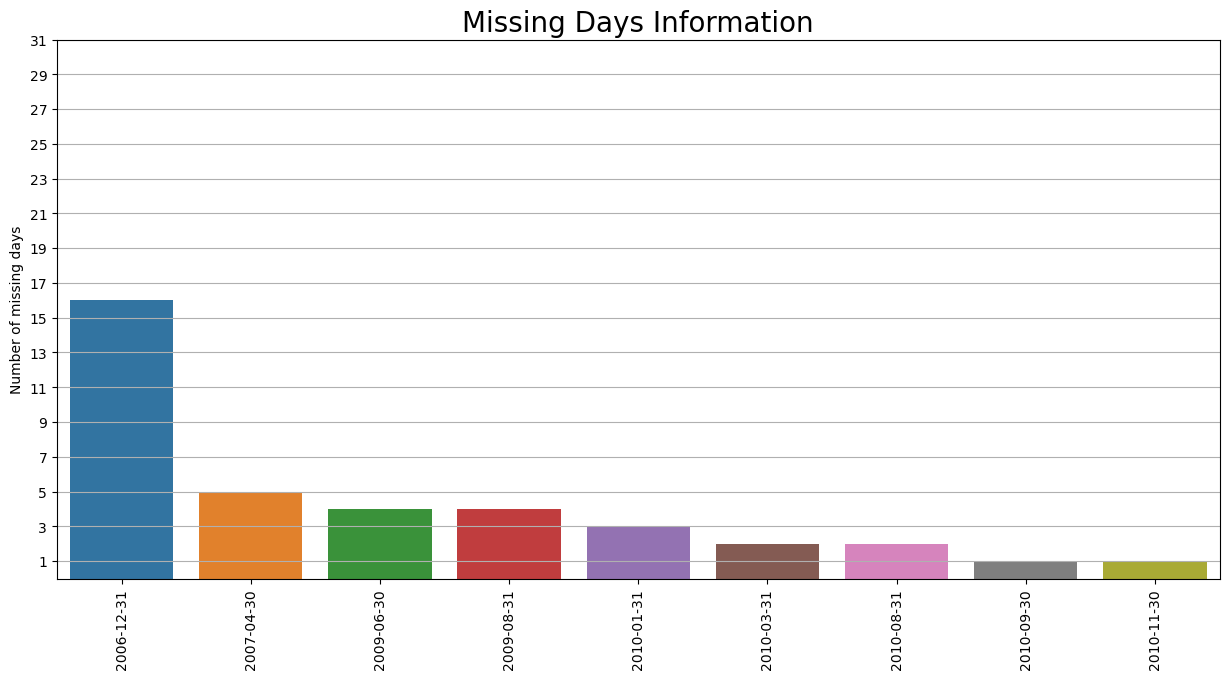

In [7]:
'''
    In the first place I would like to determine the accuracy of the data recording
    in our dataset, including any data gaps and their duration, and the
    range of days for which data was recorded.
'''
# Let's find out how many days have not been recored in our dataset
missing_days_df = np.round(data[['Global_active_power']].resample('m').count()/1440).astype(int)
missing_days_df.columns = ['Number of missing days']
missing_days_df['Number of missing days'] = missing_days_df.index.astype(str).str[-2:].astype(int) - missing_days_df['Number of missing days']
# Drop the rows where the number of missing days is 0
missing_days_df.drop(missing_days_df[missing_days_df['Number of missing days']==0].index,inplace=True)

# Drawing the plot
plt.figure(figsize=(15,7))
sns.barplot(
    data = missing_days_df,
    x = missing_days_df.index.date,
    y = missing_days_df.sort_values(by=['Number of missing days'],ascending=False)['Number of missing days']
)
plt.xticks(rotation = 90)
plt.yticks(np.arange(1,32,2))
plt.xlabel('')
plt.grid(axis='y')
plt.title('Missing Days Information',fontsize=20)
plt.show()

- <b>Conclusion</b>
    - It's noticeable that the data contains gaps and there may be multiple reasons for this.<br> It appears that the data collection for the first month didn't start from the beginning <br>of the month and a similar scenario happened in the last month of data collection.

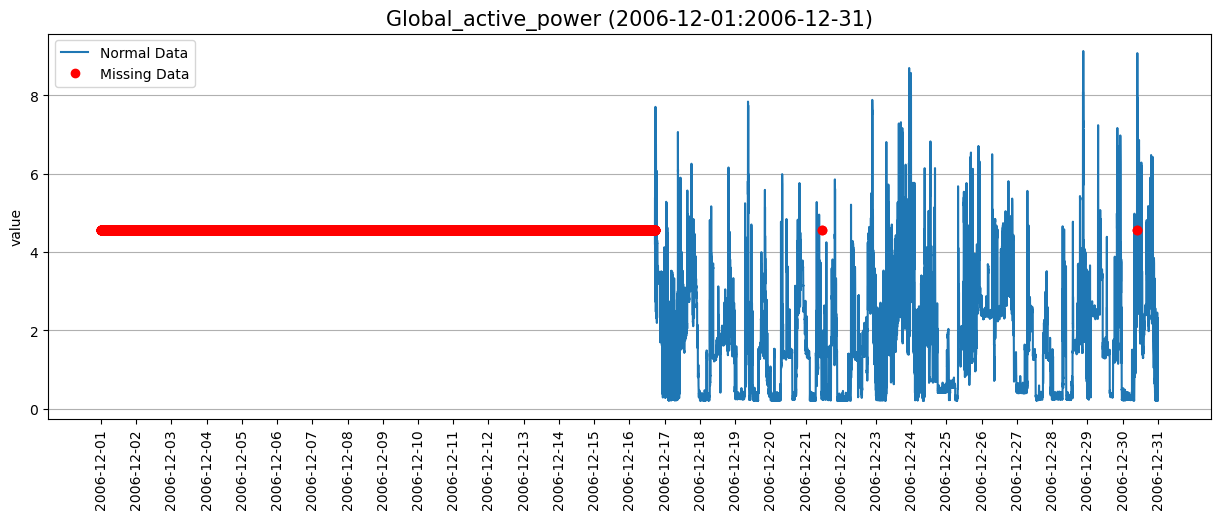

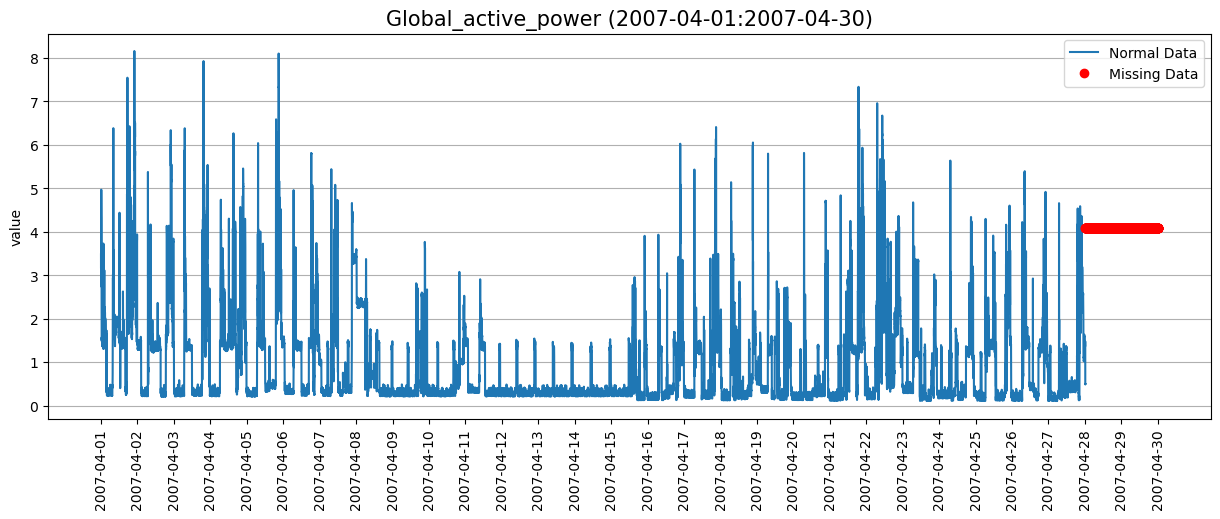

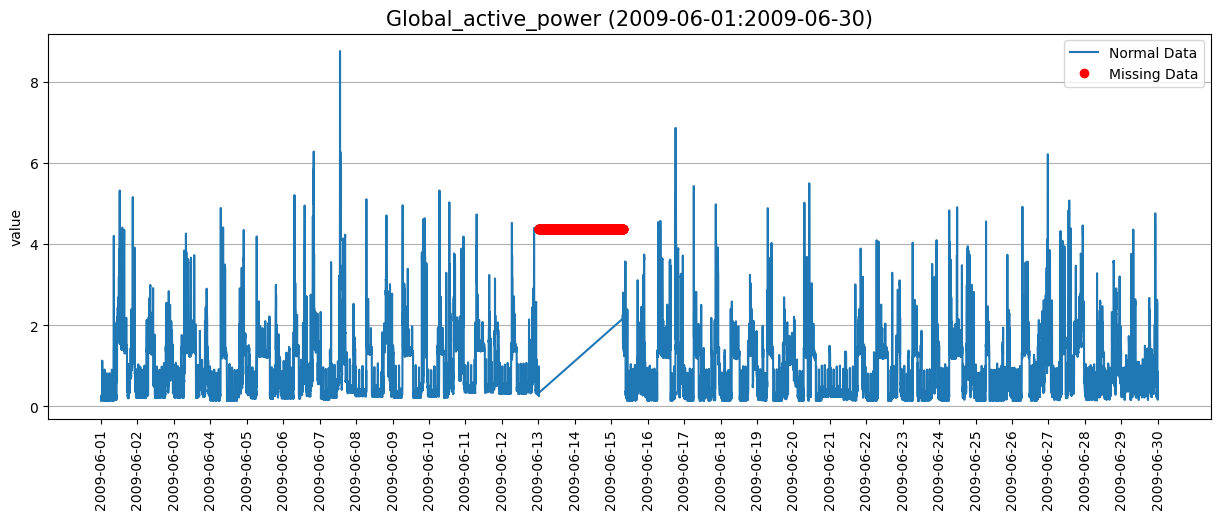

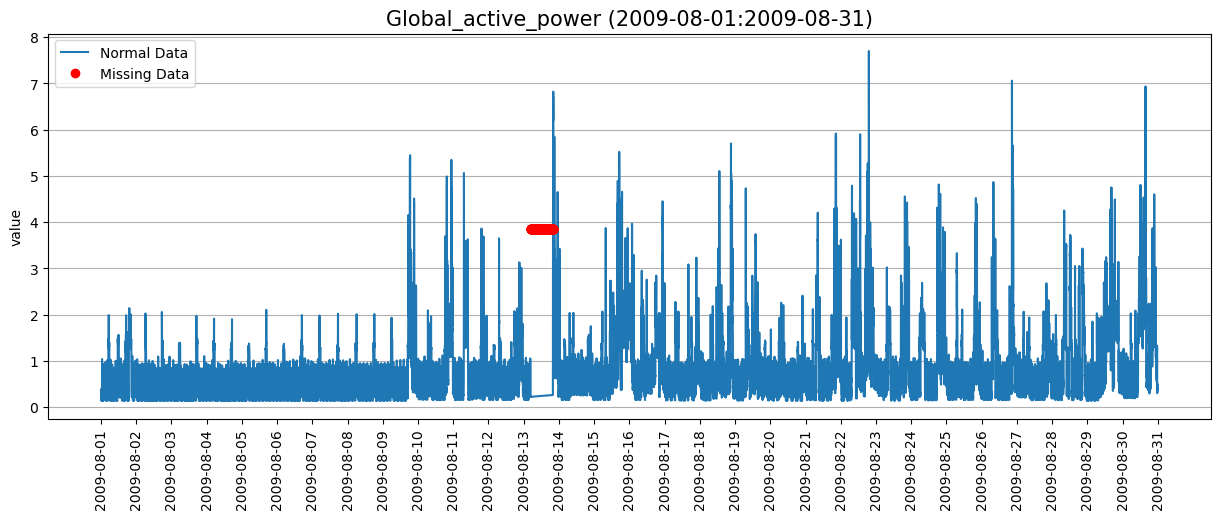

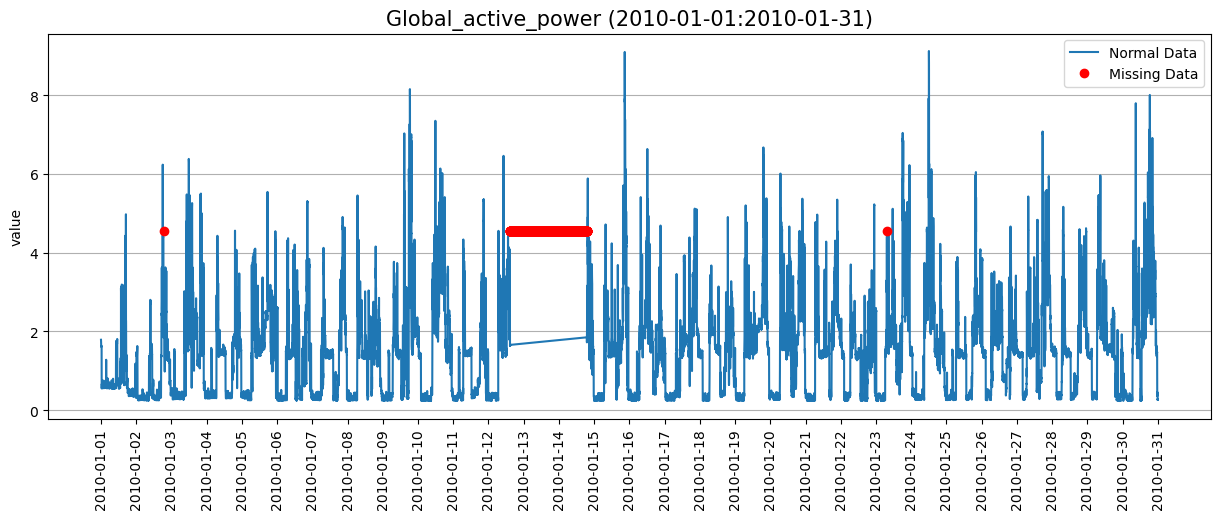

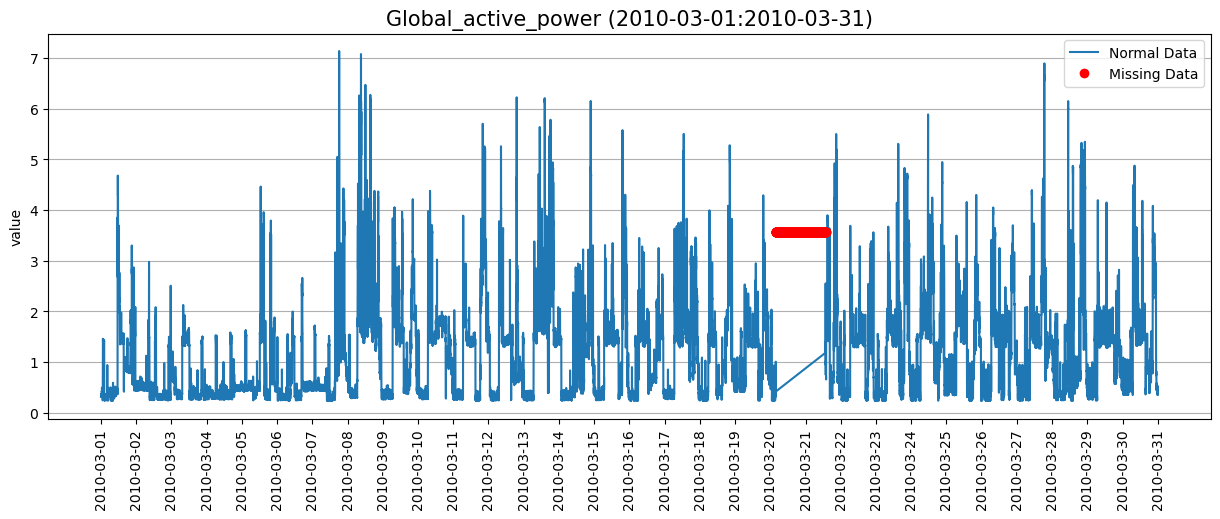

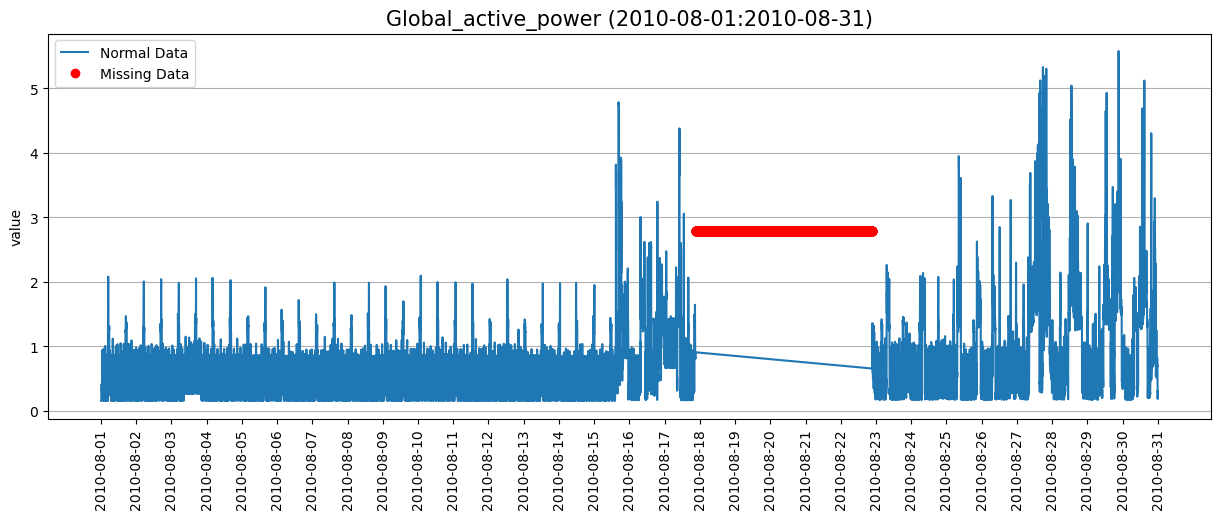

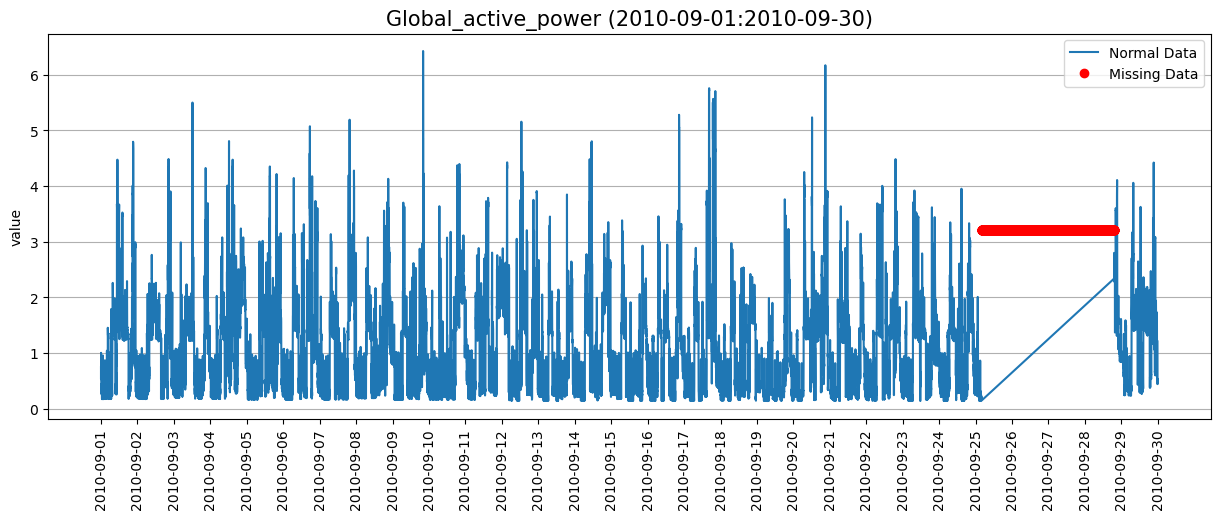

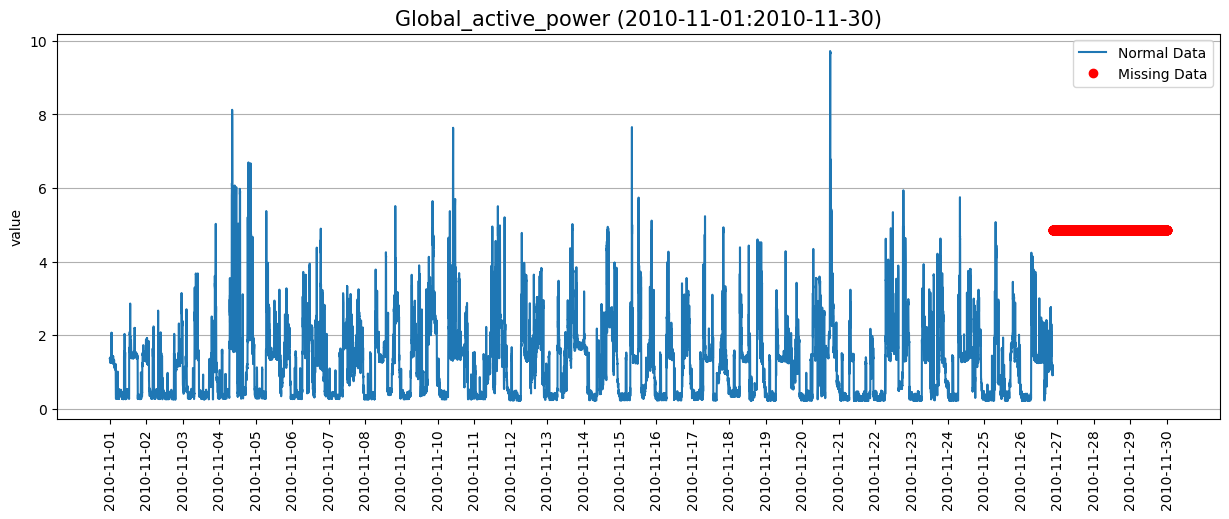

In [8]:
for day in missing_days_df.index.date:
    plot_day_data(day)

- <b>Conclusion</b>
    - As I suspected, the data collection didn't commence on day one but instead began on <br>the 17th and concluded on the 27th. The absence of data on certain days suggests <br>the possibility of power failures or problems with the sensors that were tasked with recording the data.

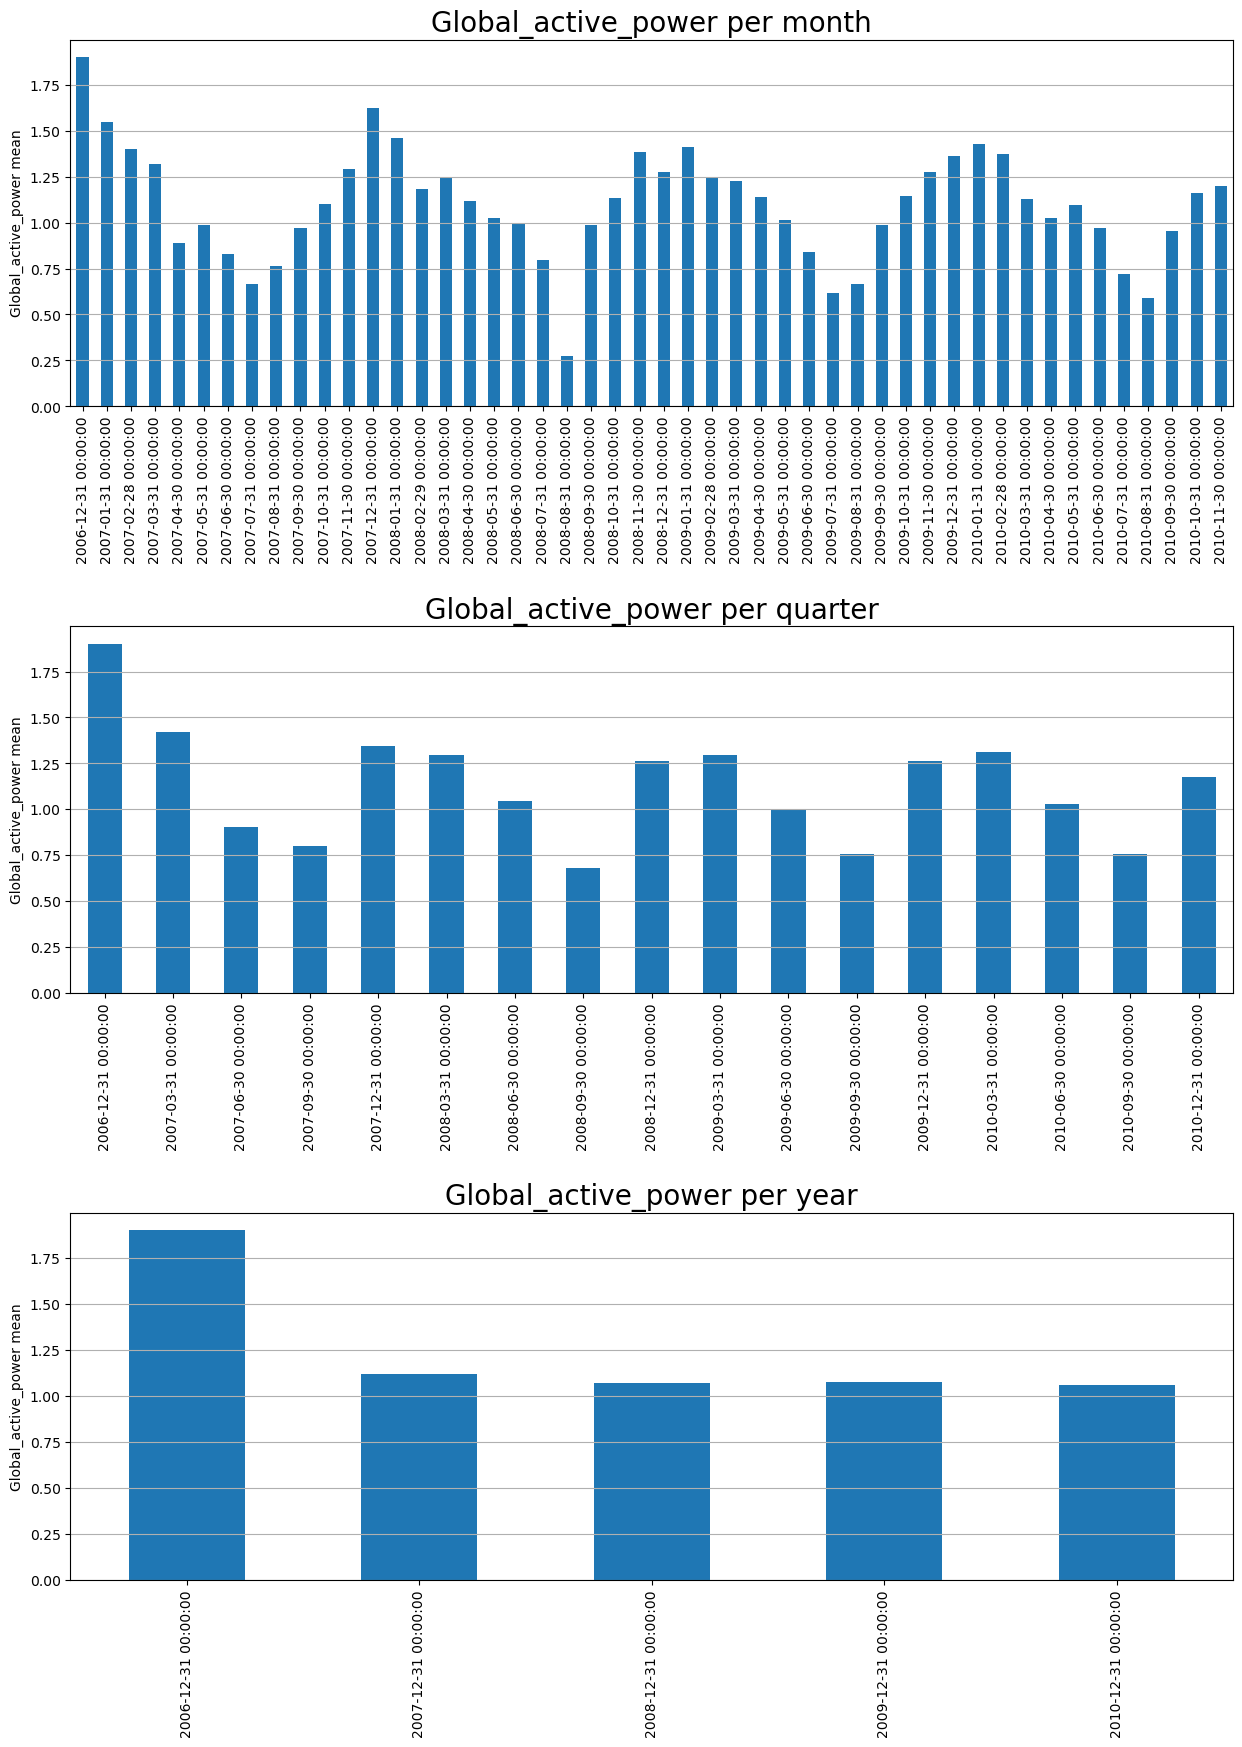

-----------------------------


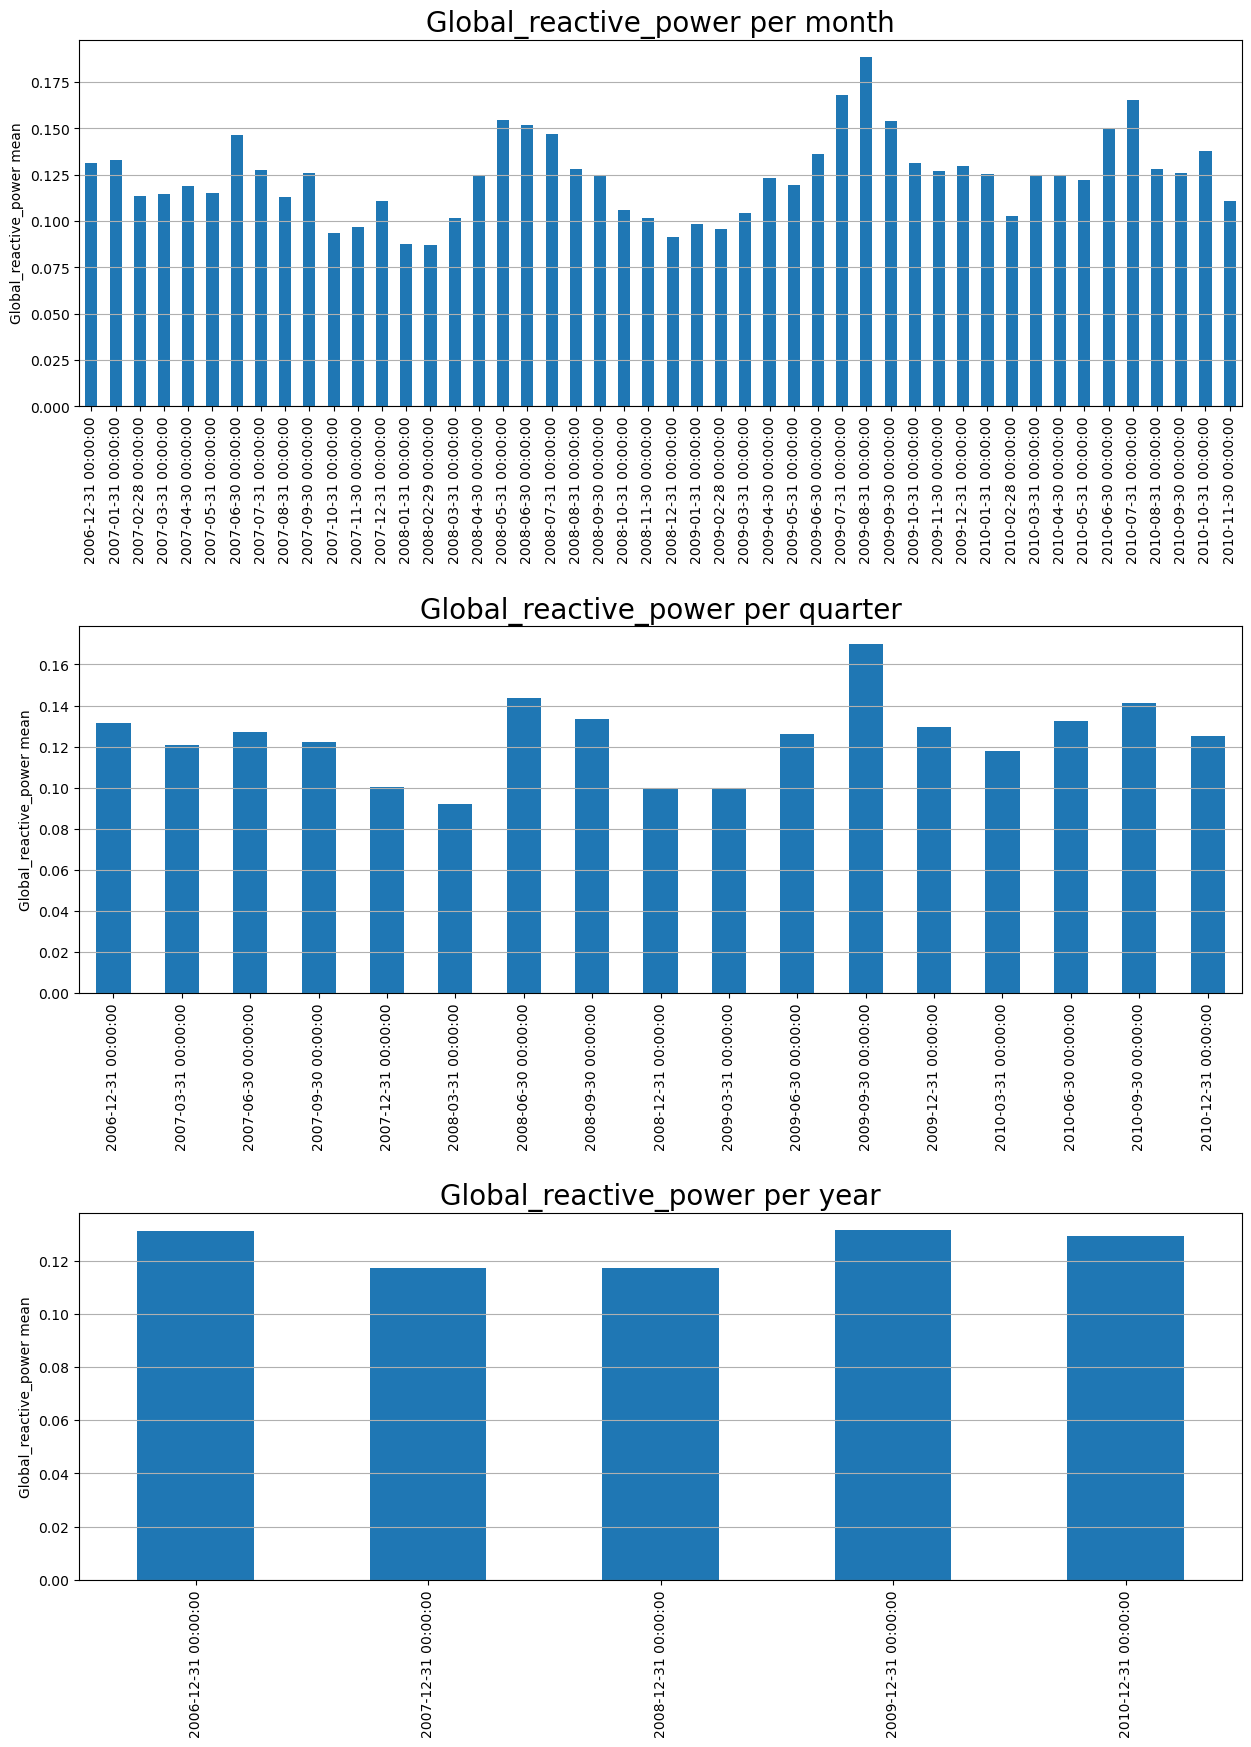

-----------------------------


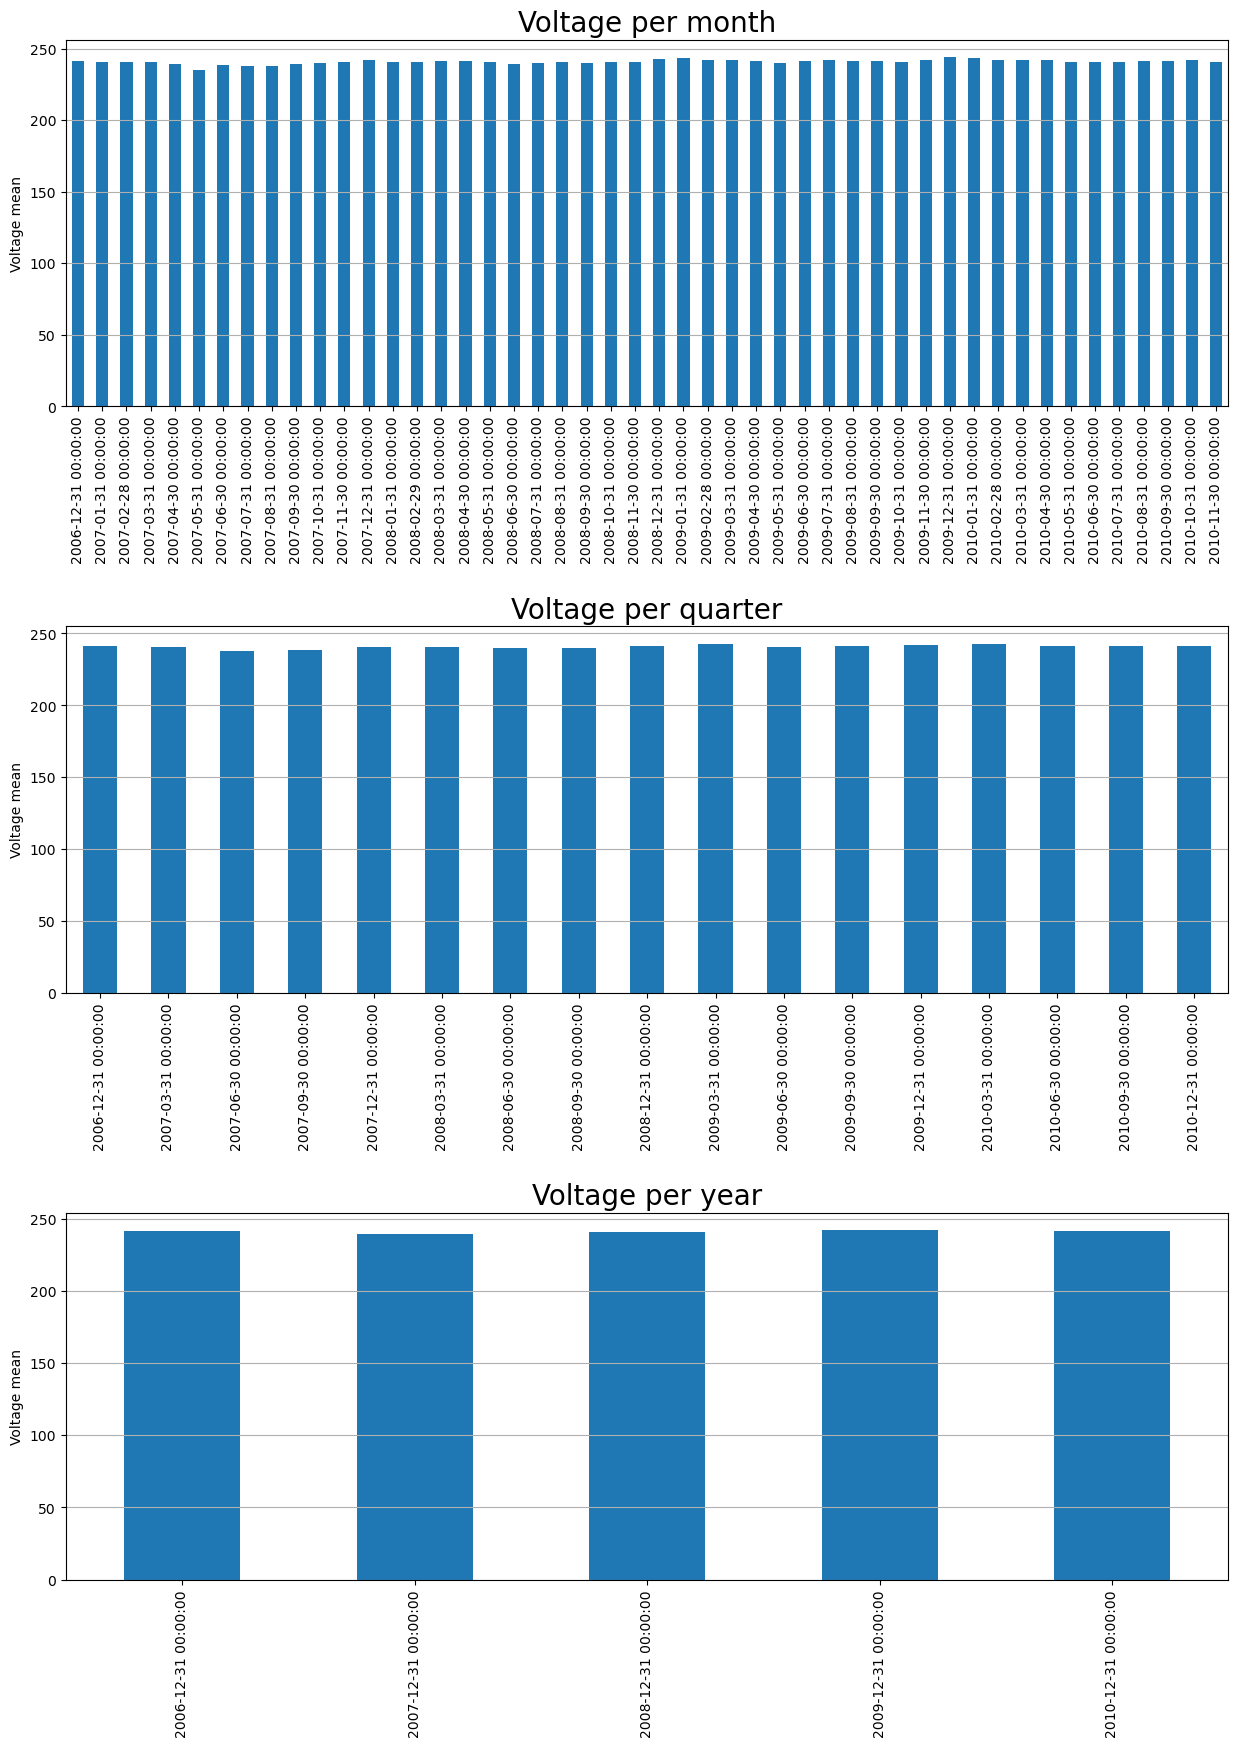

-----------------------------


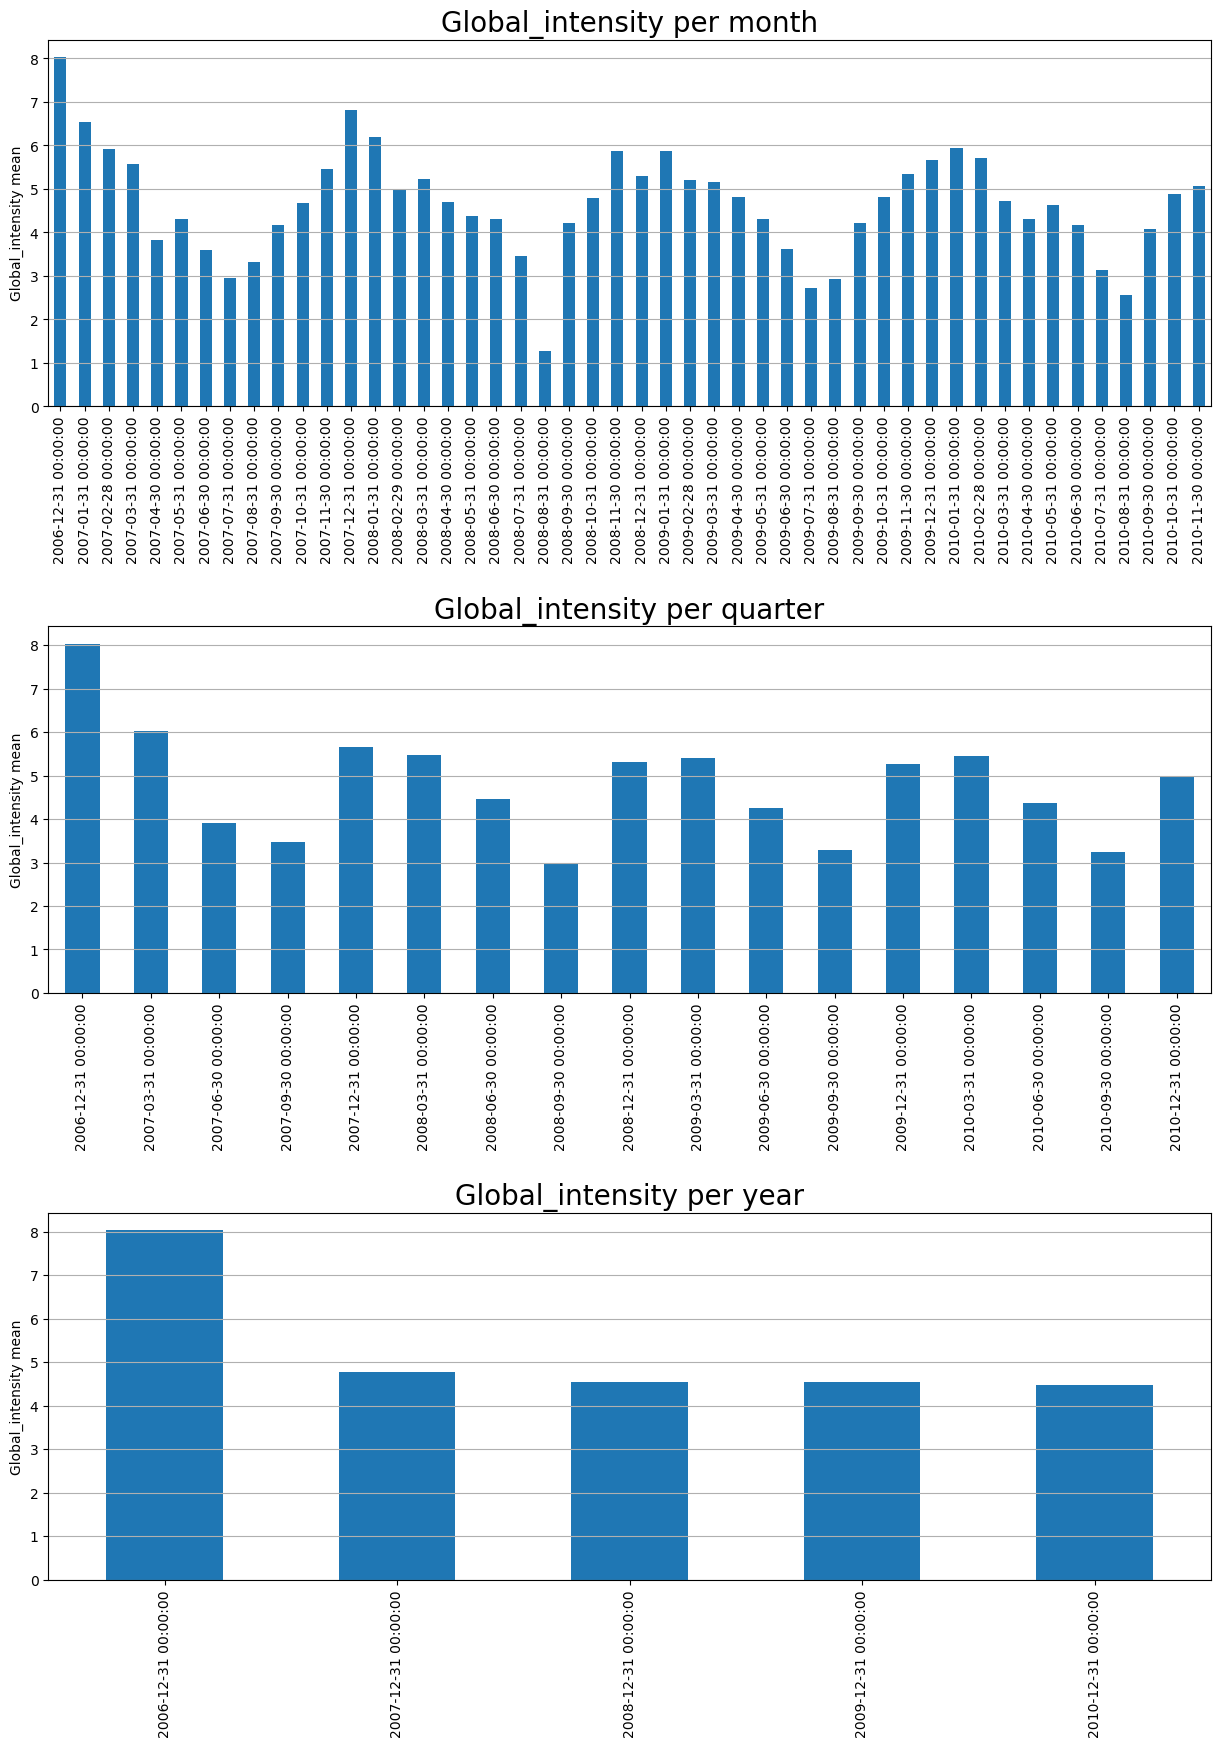

-----------------------------


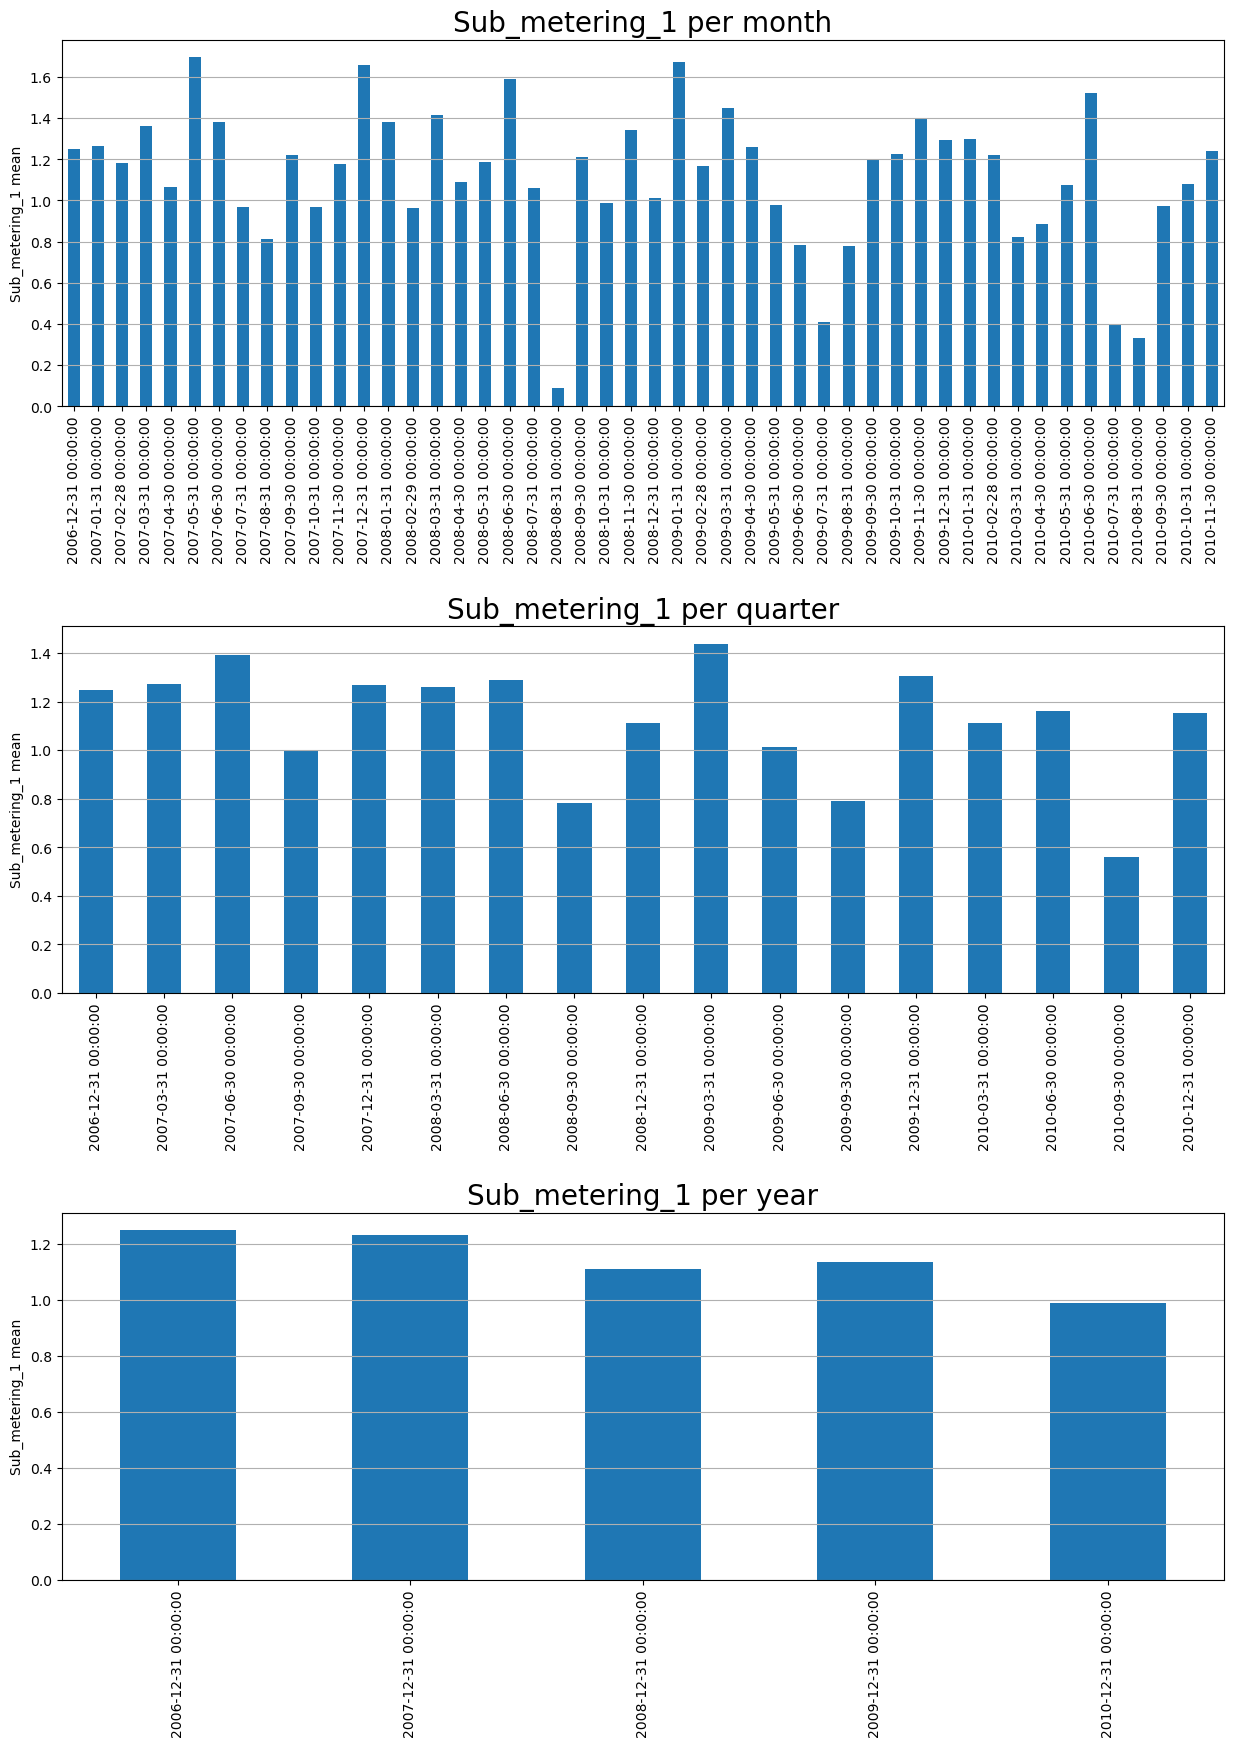

-----------------------------


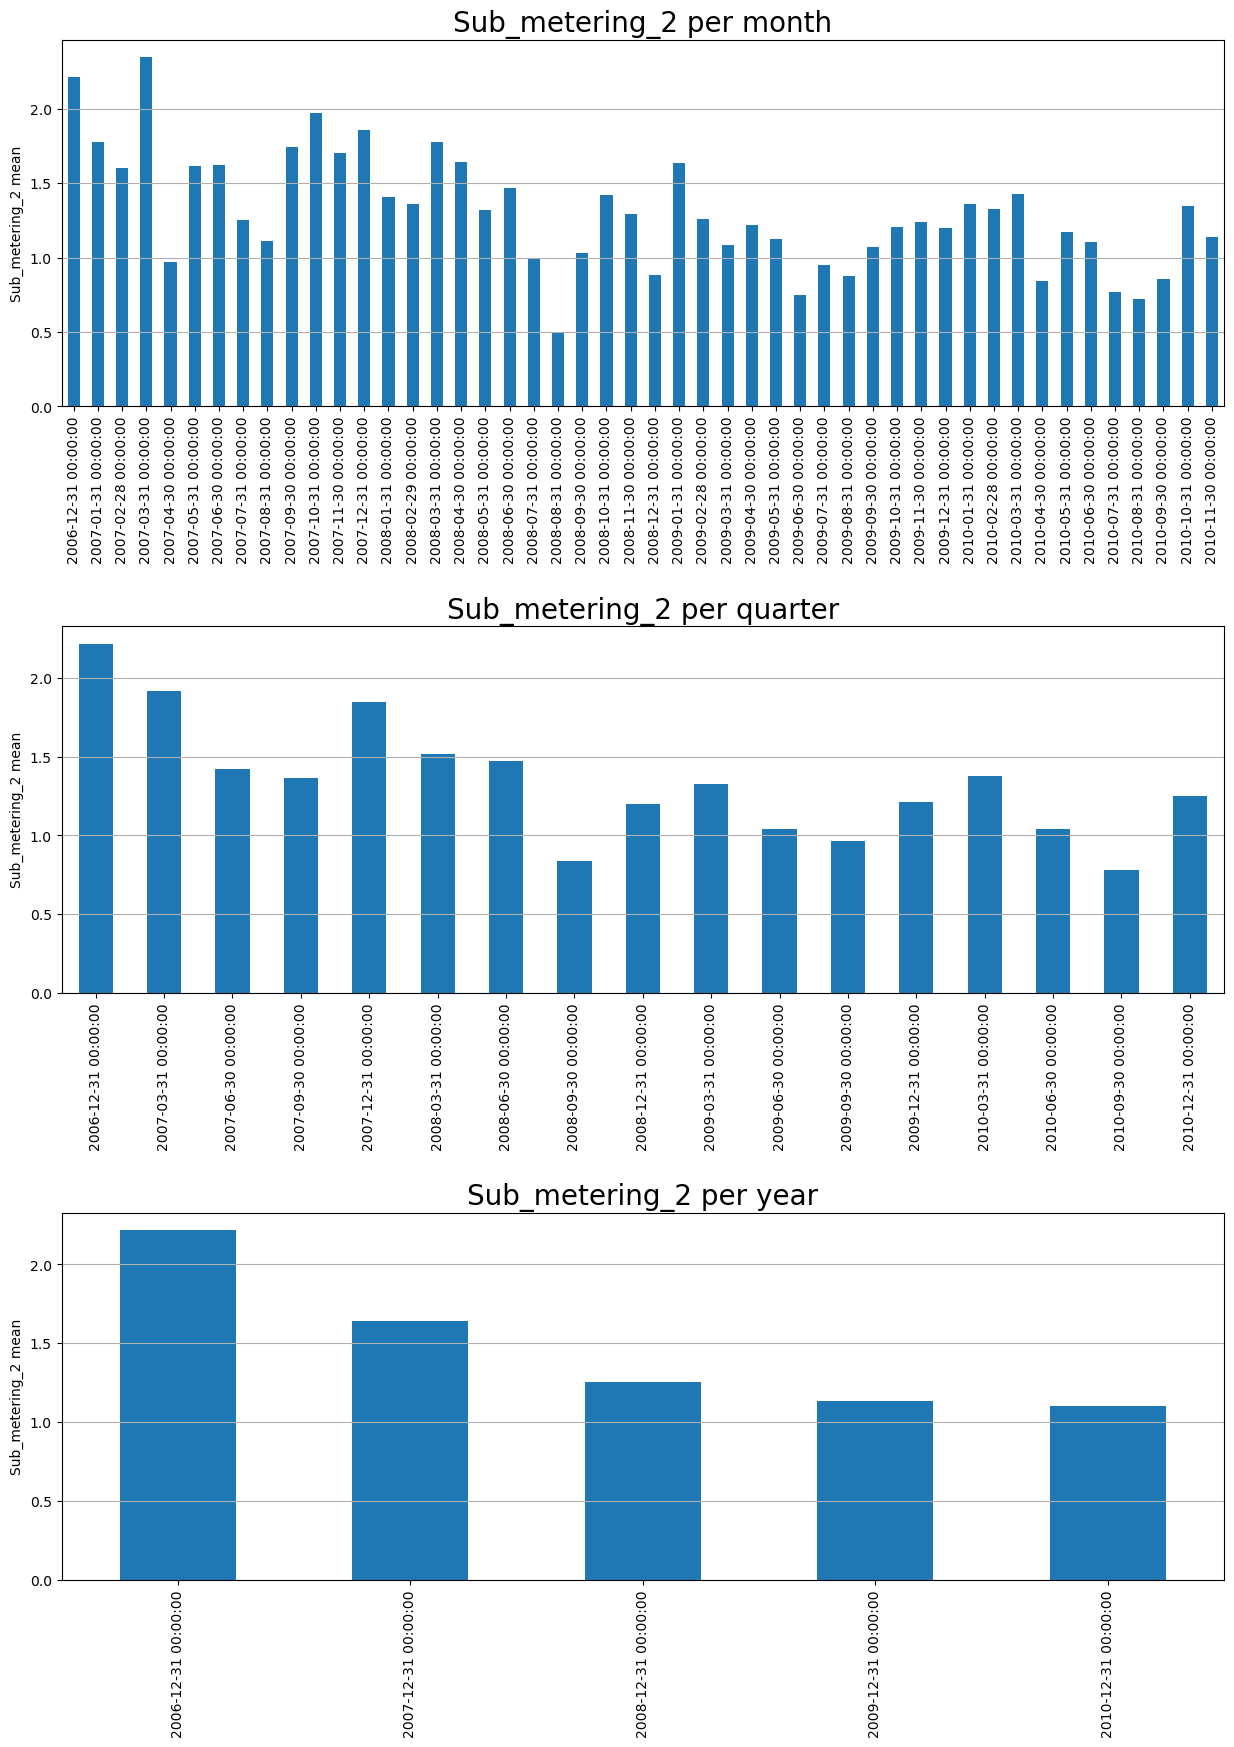

-----------------------------


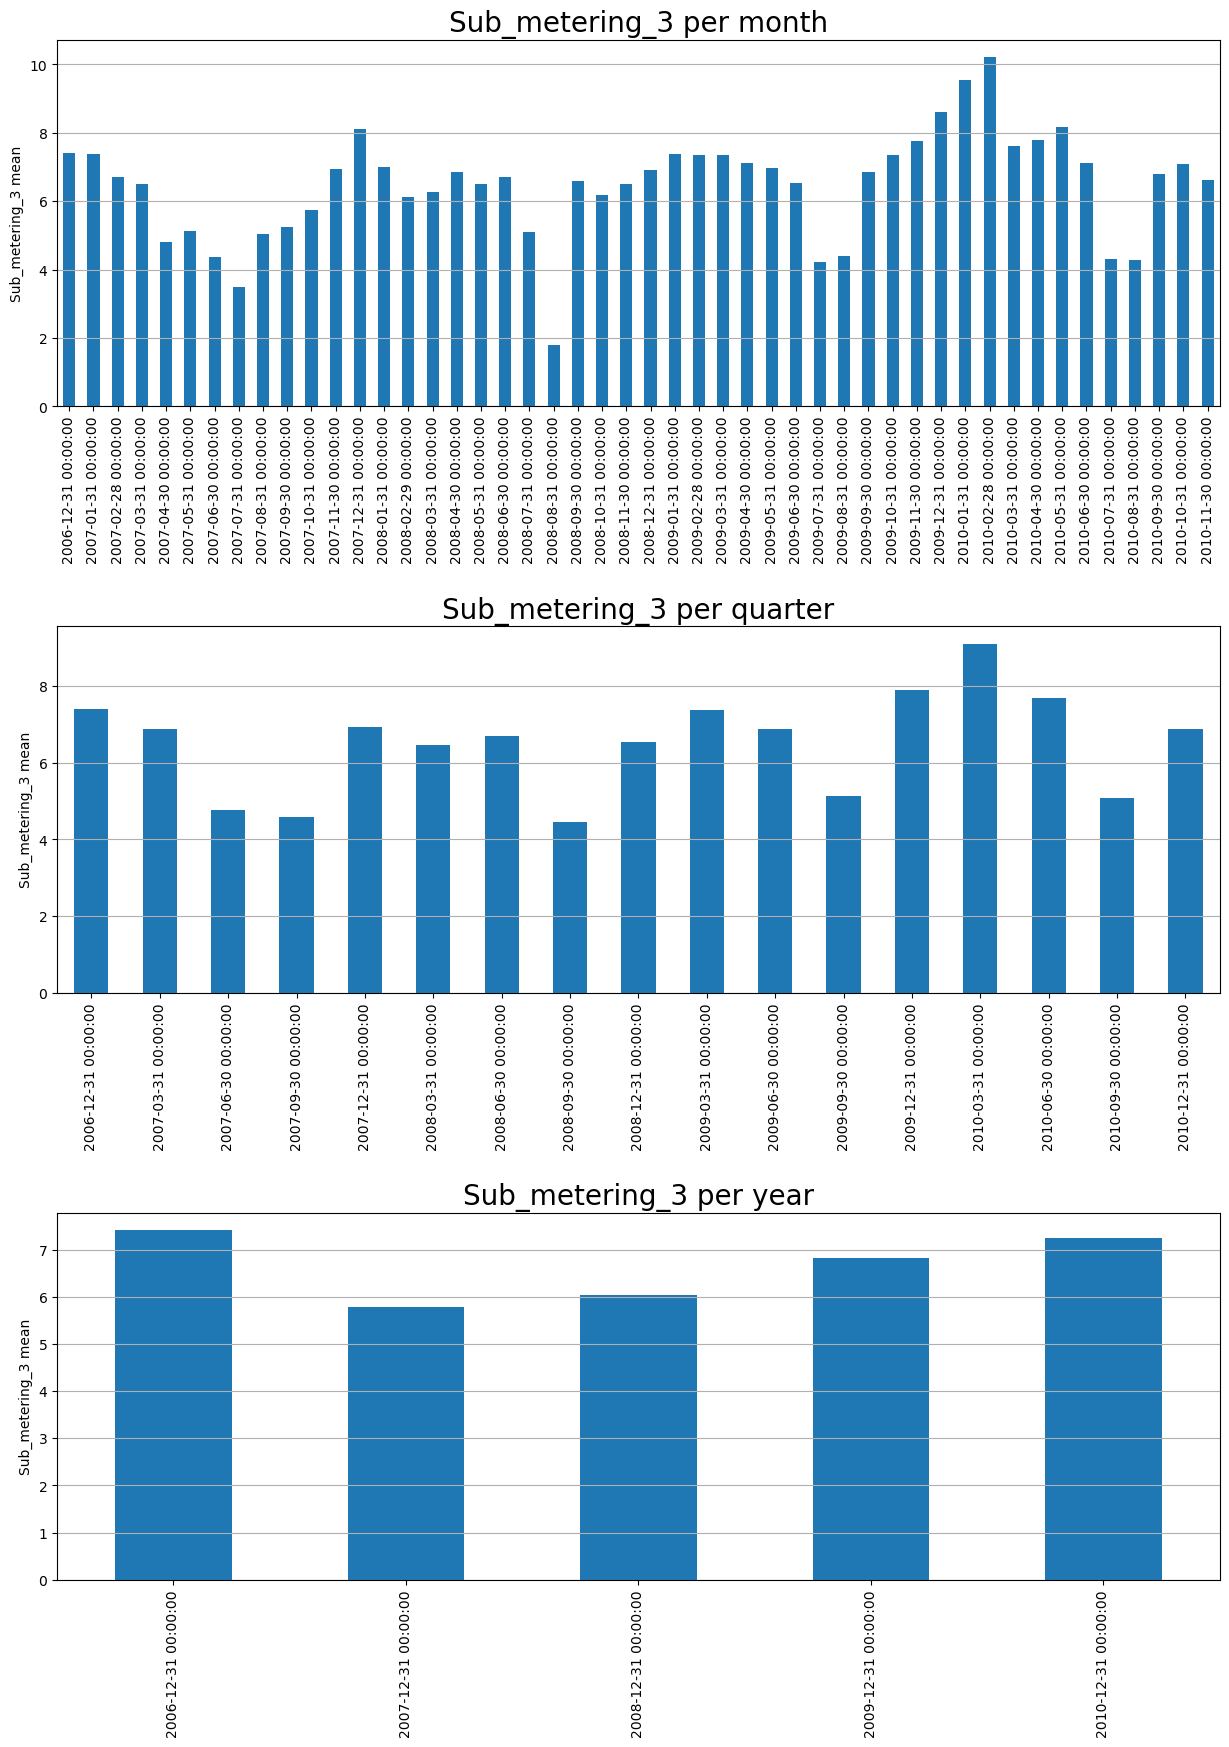

-----------------------------


In [9]:
for i in data.columns:
    feature_analyser(i,data)

- <b>Conclusion</b>
    - The information contained in the charts suggests that the global energy consumption follows a pattern similar to a <br>Gaussian distribution, with a higher demand during winter and lower demand during summer.<br> Moreover, the voltage remained unchanged throughout the monitoring period. Additionally,<br> the sub_metering2 sensor shows a decrease, indicating a decline in the washing-related <br>business, leading to a reduction in total energy consumption over time.

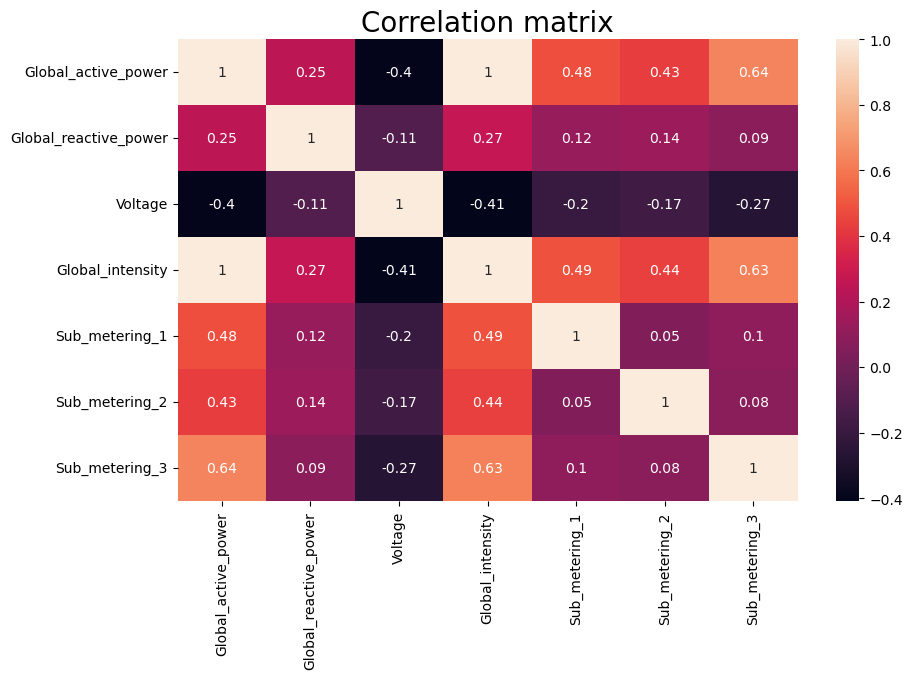

In [10]:
'''
    A correlation matrix is a table showing correlation 
    coefficients between a set of variables. Each cell in 
    the table shows the correlation between two variables. 
    Correlation matrices are used to summarize data, as an 
    input into a more advanced analysis, and as a 
    diagnostic for advanced analyses.
'''

# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(data.corr().round(2),annot=True)
plt.title('Correlation matrix',fontsize = 20)
plt.show()

- <b>Conclusion</b>
    - By analyzing the information from the correlation matrix, it is clear that the variables<br> <b>'Global_active_power'</b> and <b>'Global_intensity'</b> have a strong interdependence. <br>As a result, it will be necessary to eliminate one of them.

In [11]:
data.drop(columns=['Global_intensity'],inplace=True)

## Machine-Learning: LSTM Data Preparation and feature engineering

In [69]:
# Resample the data to obtain hourly means
df_reshaped = data.resample('D').mean()

# Feature engine
'''
    Based on the analysis of the data distribution, 
    it is evident that the variables exhibit distinct 
    seasonality. Therefore, we have generated two new
    variables, namely the day of the week and the season.
'''
df_reshaped['weekday'] = [get_weekday(day) for day in df_reshaped.index]
df_reshaped['season'] = [get_season(day) for day in df_reshaped.index]

# Encoding
oh = OneHotEncoder(drop_last=True,variables=['weekday','season'])
df_reshaped = oh.fit_transform(df_reshaped)

# Create a dataframe suitable for input into an LSTM model
LSTM_df = LSTM_df_generator(df_reshaped,rows_before=2)

# Split the data into training and test sets
X_train,X_test,y_train,y_test = train_test_split(
    LSTM_df.drop(LSTM_df.columns[[-1]],axis=1),
    LSTM_df[LSTM_df.columns[-1]].values,
    test_size=0.2,
    # Do not shuffle the data (shuffle=False)
    shuffle=False
)

In [70]:
# Initialize the MinMaxScaler
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()

# Scale the training and test data
X_train,X_test = sc_x.fit_transform(X_train),sc_x.transform(X_test)
y_train,y_test = sc_y.fit_transform(pd.DataFrame(y_train)),sc_y.transform(pd.DataFrame(y_test))

# Reshape the training and test data to include a time dimension
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

In [71]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=20
)
checkpointer = ModelCheckpoint(
    filepath='household_power_consumption_model.h5', 
    save_best_only=True,
    monitor='mse'
)

In [72]:
# Initialize the KerasRegressor model
model = KerasRegressor(
    model=create_model,
    validation_split=0.2,
    validation_batch_size=50,
    callbacks=early_stopping,
    verbose=0,
    shuffle=False
)

# Define the hyperparameter grid to search over
param_grid = {
    'model__optimizer': [Adam, SGD, RMSprop, Adamax],
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__dropout_rate': [0.1, 0.2, 0.3],
    'model__batch_size': [100,500], 
    'model__units': [50, 100, 200],
    'model__epochs': [20,50]
}

# Initialize the GridSearchCV with the model and hyperparameter grid
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid,
    cv=5, 
    n_jobs=-2,
    scoring='neg_mean_absolute_error',
    error_score='raise'
)

# Fit the model using the GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best accuracy
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'model__batch_size': 500, 'model__dropout_rate': 0.1, 'model__epochs': 20, 'model__learning_rate': 0.01, 'model__optimizer': <class 'keras.optimizers.optimizer_v2.adamax.Adamax'>, 'model__units': 50}
Best accuracy found:  -0.08590929819068699


## Final best model

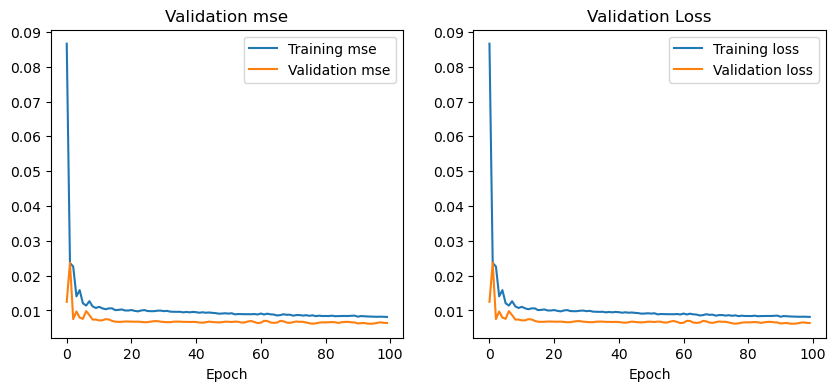

In [73]:
# Define parameters
batch_size = grid_search.best_params_['model__batch_size']
epochs = grid_search.best_params_['model__epochs']

# Define model
model = create_model(
    units=grid_search.best_params_['model__units'],
    dropout_rate=grid_search.best_params_['model__dropout_rate'],
    optimizer=grid_search.best_params_['model__optimizer'],
    learning_rate=grid_search.best_params_['model__learning_rate'],
)

# Fitting model
history = model.fit(
    X_train, 
    y_train,
    batch_size = 500,
    epochs = 100,
    verbose=0,
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping, checkpointer]
)

# Evaluating plots
fig, axs = plt.subplots(1, 2,figsize=(10,4))

# Get the length of the data
history_len = len(history.history['mse'])

# Create a dictionary to store the plots, labels and titles
plots = {
    'mse':['mse','val_mse','Validation mse'],
    'loss':['loss','val_loss','Validation Loss'],
}

# Iterate over the dictionary and plot the data
for i, (key,value) in enumerate(plots.items()):
    # Plot the training and validation data
    axs[i].plot(range(history_len), history.history[value[0]],label = f'Training {key}')
    axs[i].plot(range(history_len), history.history[value[1]],label = f'Validation {key}')
    # Add the legend
    axs[i].legend()
    # Set the title
    axs[i].set_title(value[2])
    # Set the x-axis label
    axs[i].set_xlabel('Epoch')
# Show the plot
plt.show()

9/9 [==============================] - 0s 1ms/step


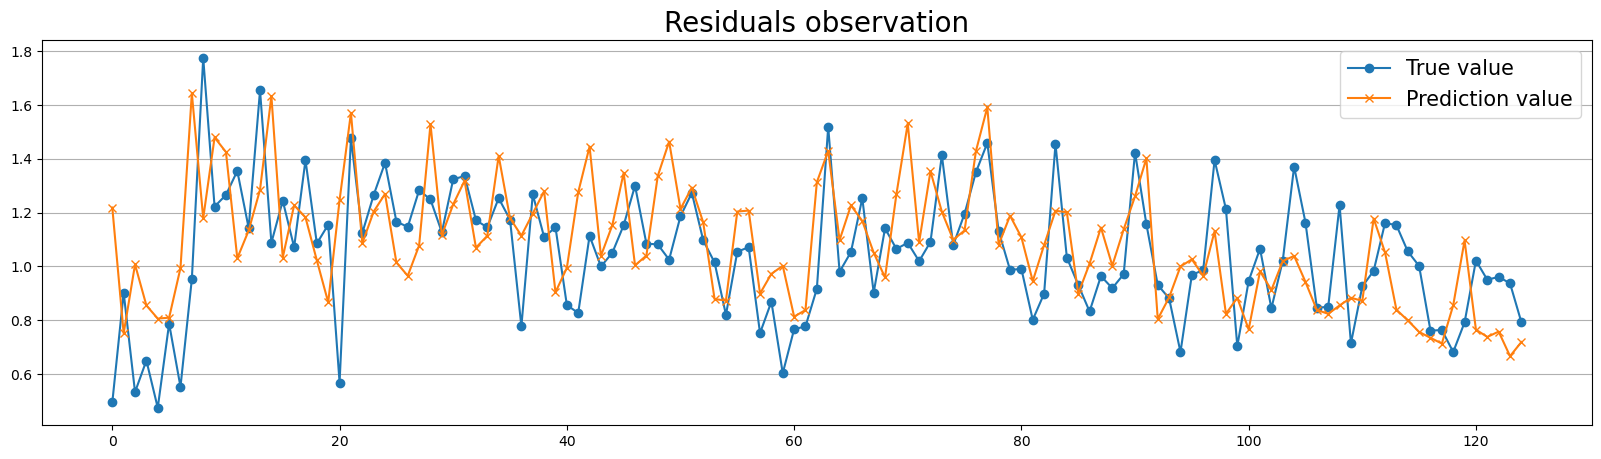

In [74]:
# Define y_true, y_head 
y_true = pd.DataFrame(sc_y.inverse_transform(y_test)[25:150])
y_head = pd.DataFrame(sc_y.inverse_transform(model.predict(X_test)[25:150]))

# Drawing the plot
plt.figure(figsize=(20,5))
plt.plot(y_true, marker = 'o', label = "True value",)
plt.plot(y_head, marker = 'x', label = "Prediction value",linestyle = '-')
plt.legend(fontsize=15,loc=1)
plt.grid(axis='y')
plt.title('Residuals observation',fontsize = 20)
plt.show()

In [75]:
print(f'The mean absolute error on the test is : {np.round(mean_absolute_error(y_true,y_head),2)} KW per day')
print(f'The mean squared error on the test is : {np.round(mean_squared_error(y_true,y_head),2)} KW per day')

The mean absolute error on the test is : 0.19 KW per day
The mean squared error on the test is : 0.06 KW per day


## Conclusion
- I found the project very engaging because it allowed me to acquire knowledge about LSTM models for predicting energy consumption data. The dataset contained a small number of missing values, which we deleted, and we assessed the sectors that had the highest concentration of missing data.

- Our team utilized GridSearchCV to identify the optimal model parameters. During performance evaluation, we utilized the 'Mean absolute error' metric. The process of tuning parameters took approximately 6 hours.

- Ultimately, the model displayed exceptional performance, and the loss plots converged, which suggests that the model architecture is sound."

- We have the option to resample this dataset to acquire data at an hourly, daily, or yearly frequency, and this could affect our selection of time series for building our model. Additionally, we have the freedom to decide on the time interval for which we want to generate predictions.